<a href="https://colab.research.google.com/github/lobabacar/test_git/blob/main/Copie_de_Notebook_1_ResNet_on_EuroSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#@title 1. 🏗️ Library Installation
!pip3 -qqq install rasterio python-dotenv pytorch-lightning wandb #lightning-bolts lightning-flash wandb rich


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 36.4 MB/s eta 0:00:00


Optionnaly, we can improve the message formatting:

In [4]:
from rich import pretty, print, inspect, traceback
from rich.progress import track
pretty.install()
#traceback.install()

In [5]:
import logging
from rich.logging import RichHandler

FORMAT = "%(message)s"
logging.basicConfig(level= logging.ERROR, format=FORMAT, datefmt="[%X]", handlers=[RichHandler(rich_tracebacks=True)],  # <- not sets rich_tracebacks
)

Check that you have a GPU:

In [1]:
!nvidia-smi
!lscpu

Thu Nov 14 15:52:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
print(device)

cuda

In [7]:
%load_ext autoreload
%autoreload 2
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics
import os
import numpy as np
import cv2 as cv
import time
import torch
import torchvision
import collections
import tqdm
import json
import requests
import zipfile
import rasterio #gdal
import gdown, glob
import torch
import torch.nn.functional as F
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics.functional import accuracy
from torchvision import transforms
import wandb

# ⬇ Data Downloading

In [8]:
import gdown
gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=1TvTAn9kECHaB29lRMd6P4VQivALq6qiI",
        '/content/EuroSATallBands.zip'
    )


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1TvTAn9kECHaB29lRMd6P4VQivALq6qiI
To: /content/EuroSATallBands.zip
100%|██████████| 2.07G/2.07G [00:25<00:00, 81.7MB/s]


'/content/EuroSATallBands.zip'

Si cela ne fonctionne pas:
1. Monter votre Google Drive
2. https://drive.google.com/file/d/1TvTAn9kECHaB29lRMd6P4VQivALq6qiI/edit
3. cliquer en haut à droite (ajouter shortcut)
4. utiliser le chemin /content/drive/MyDrive/...


We extract the files (takes 40s), the files are available in `/content/ds/images/remote_sensing`:



In [9]:
!unzip --help

UnZip 6.00 of 20 April 2009, by Debian. Original by Info-ZIP.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files as text
  -U  use escapes for all non-ASCII Unicode  -UU ignore any Unicode fields
  -C  mat

In [10]:
!unzip -qo /content/EuroSATallBands.zip -d /content/

The data is organized as following:

```
/content/ds
└── images
    └── remote_sensing
        └── otherDatasets
            └── sentinel_2
                └── tif
                    ├── AnnualCrop
                    ├── Forest
                    ├── HerbaceousVegetation
                    ├── Highway
                    ├── Industrial
                    ├── Pasture
                    ├── PermanentCrop
                    ├── Residential
                    ├── River
                    └── SeaLake
```



The classes are the following

In [11]:
import glob
import os
class_names = []
for f in glob.glob('/content/ds/images/remote_sensing/otherDatasets/sentinel_2/tif/*'):
  class_names.append(os.path.basename(f))
#inspect(class_names, methods=True)
print(class_names)


[
    'AnnualCrop',
    'Highway',
    'Pasture',
    'Forest',
    'SeaLake',
    'Industrial',
    'PermanentCrop',
    'Residential',
    'HerbaceousVegetation',
    'River'
]

# 📁 Dataset Construction
Afin de controler l'aspect aléatoire, il est possible de fixer une valeur de seed

In [12]:
SEED = 100
import torch
import pytorch_lightning
pytorch_lightning.seed_everything(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(seed=SEED)
import random
random.seed(a=SEED)
torch.backends.cudnn.deterministic = True

INFO:lightning_fabric.utilities.seed:Seed set to 100


In [13]:
class EuroSATDataset(torch.utils.data.Dataset):

  def __init__(self, datadir, target_bands= [2,3,4,8]):
    assert os.path.isdir(datadir)
    self.class_name = [
    'Forest',
    'Residential',
    'SeaLake',
    'Industrial',
    'AnnualCrop',
    'Highway',
    'River',
    'HerbaceousVegetation',
    'Pasture',
    'PermanentCrop'
    ]
    self.samples = []
    for class_idx, class_set in enumerate(self.class_name):
      for f in glob.glob(os.path.join(f'{datadir}/images/remote_sensing/otherDatasets/sentinel_2/tif/',class_set,'*.tif')):
        self.samples.append((f, class_idx))
    self.target_bands = target_bands
    self.patch_size = 9
  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    sample = self.samples[idx]
    raster_path = sample[0]
    raster_ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    assert raster_ds is not None, f"File not found: {raster_path}"
    image = []
    for channel in self.target_bands:
        image_arr = raster_ds.GetRasterBand(channel).ReadAsArray()
        assert image_arr is not None, f"Band not found: {channel}"
        image.append(image_arr)
    image = np.dstack(image)
    raster_ds = None

    image = (image.astype(np.float32) - 127.0) / 128.0
    image = torchvision.transforms.functional.to_tensor(image)
    image = torchvision.transforms.functional.center_crop(image, output_size=self.patch_size)
    return image, sample[1]  # return tuple with class index as 2nd member



We check the dataset:

In [14]:
target_bands = [2, 3, 4, 8]  # ce sont les bandes telles qu'utilisées à l'entraînement
dataset = EuroSATDataset("/content/ds", target_bands)
print(dataset[0][0].shape)
print(f"dataset size = {len(dataset)}")

NameError: name 'gdal' is not defined

# 🧠 ResNet Construction
We build the ResNet-18 architecture.

The first step is to create a ResNet block:

![](https://d2l.ai/_images/resnet-block.svg)


In [ ]:
class ResNetBlock(torch.nn.Module):
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        self.inplanes = inplanes
        self.planes = planes
        self.stride = stride
        self.downsample = downsample
        self.conv1 = torch.nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(planes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = torch.nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(planes)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


The ResNet-18 is composed of 4 blocks:

In [ ]:
class ResNet18(torch.nn.Module):

    def __init__(self, num_classes=10, layers=[2, 2, 2, 2], strides=[1, 2, 2, 2], input_channels=4):
        super().__init__()
        self.inplanes = 64
        self.conv1 = torch.nn.Conv2d(in_channels=input_channels, out_channels=self.inplanes,
                                     kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(self.inplanes)
        self.relu = torch.nn.ReLU(inplace=True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(ResNetBlock, 64, layers[0], stride=strides[0])
        self.layer2 = self._make_layer(ResNetBlock, 128, layers[1], stride=strides[1])
        self.layer3 = self._make_layer(ResNetBlock, 256, layers[2], stride=strides[2])
        self.layer4 = self._make_layer(ResNetBlock, 512, layers[3], stride=strides[3])
        self.out_features = 512
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(self.out_features, num_classes)
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(self.inplanes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                torch.nn.BatchNorm2d(planes * block.expansion),
            )
        layers = [block(self.inplanes, planes, stride, downsample)]
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return torch.nn.Sequential(*layers)

    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        #print(x.shape)
        x = self.bn1(x)
        x = self.relu(x)
        #print(x.shape)
        x = self.maxpool(x)
        #print(x.shape)
        x = self.layer1(x)
        #print(x.shape)
        x = self.layer2(x)
        #print(x.shape)
        x = self.layer3(x)
        #print(x.shape)
        embedding = self.layer4(x)
        #print(embedding.shape)
        logits = self.avgpool(embedding)
        #print(logits.shape)
        logits = logits.view(x.size(0), -1)
        #print(logits.shape)
        logits = self.fc(logits)
        return logits

In [ ]:
model= ResNet18(layers=[1,1,1,1])

In [ ]:
BATCH_SIZE= 96

In [ ]:
print(model)

ResNet18(
  (conv1): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResNetBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Sequential(
    (0): ResNetBlock(
      (downsample): Sequential(
        (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

In [ ]:
from torchsummary import summary
summary(model.cuda(), (4, 9, 9), batch_size= BATCH_SIZE)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [96, 64, 9, 9]           2,304
       BatchNorm2d-2             [96, 64, 9, 9]             128
              ReLU-3             [96, 64, 9, 9]               0
         MaxPool2d-4             [96, 64, 5, 5]               0
            Conv2d-5             [96, 64, 5, 5]          36,864
       BatchNorm2d-6             [96, 64, 5, 5]             128
              ReLU-7             [96, 64, 5, 5]               0
            Conv2d-8             [96, 64, 5, 5]          36,864
       BatchNorm2d-9             [96, 64, 5, 5]             128
             ReLU-10             [96, 64, 5, 5]               0
      ResNetBlock-11             [96, 64, 5, 5]               0
           Conv2d-12            [96, 128, 3, 3]          73,728
      BatchNorm2d-13            [96, 128, 3, 3]             256
             ReLU-14            [96, 12

https://pytorch-lightning.readthedocs.io/en/latest/notebooks/lightning_examples/datamodules.html

https://pytorch-lightning.readthedocs.io/en/latest/notebooks/course_UvA-DL/04-inception-resnet-densenet.html?highlight=augmentation

# ⚡ Packaging using PyTorch Lightning


Callback functions related to the data preparation are implemented insied the [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html) class:


In [ ]:
from sklearn.model_selection import train_test_split
class EuroSATDataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()
        self.data_dir = data_dir
        self.dims = (4, 9, 9)
        self.num_classes = 10
        self.target_bands = [2, 3, 4, 8]

    def prepare_data(self):
        # download
        eurosat_full= EuroSATDataset(self.data_dir, self.target_bands)
        self.class_names = eurosat_full.class_name
        #self.eurosat_train, self.eurosat_val = random_split(eurosat_full,[22000, 5000])
        self.eurosat_train, self.eurosat_val = train_test_split(eurosat_full, train_size= 22000, test_size= 5000, random_state= SEED)

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            eurosat_full = EuroSATDataset(self.data_dir, self.target_bands)
            #self.eurosat_train, self.eurosat_val = random_split(eurosat_full, [22000, 5000])
            self.eurosat_train, self.eurosat_val = train_test_split(eurosat_full, train_size= 22000, test_size= 5000, random_state= SEED)

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.eurosat_test = EuroSATDataset(self.data_dir, self.target_bands)

    def train_dataloader(self):
        return DataLoader(self.eurosat_train, batch_size=BATCH_SIZE, shuffle= True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.eurosat_val, batch_size=BATCH_SIZE, num_workers=2)


Callback functions related to the model training are implemented inside the [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html) class:

In [ ]:
class LitModel(LightningModule):
    def __init__(self, model, learning_rate=5e-4):

        super().__init__()

        # We take in input dimensions as parameters and use those to dynamically build model.
        self.batch_size= BATCH_SIZE
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.model = model
        self.transform = None
        self.transform = transforms.Compose(
              [
                  transforms.RandomHorizontalFlip(),
                  transforms.RandomVerticalFlip(),
              ]
        )

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training and self.transform is not None:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("trn_loss", loss, prog_bar=True)
        self.log("trn_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):

        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

In [ ]:
# Init DataModule
dm = EuroSATDataModule('/content/ds')

# Setting up your environment
It's a good idea to put your keys and tokens in a notebook. Write a `.env` files with your information and upload it in your workspace.

Get your API key at https://wandb.ai/authorize

In [ ]:
%%writefile /content/.env
WANDB_API_KEY= '3e6cc13ee78b360ec4b7bcbc03dcb1d1de96de09'
WANDB_NOTEBOOK_NAME = 'Notebook 1: ResNet on EuroSAT'

Writing /content/.env


In [ ]:
from google.colab import files
#files.download('/content/.env')
files.upload()

Then load your `.env`:

In [ ]:
from dotenv import load_dotenv
load_dotenv()

True

## 📈 WandB

> Indented block


Check that your are connected to wandb:

In [ ]:
!wandb login

wandb: Currently logged in as: sfoucher. Use `wandb login --relogin` to force relogin


https://pytorch-lightning.readthedocs.io/en/stable/extensions/generated/pytorch_lightning.loggers.WandbLogger.html
https://wandb.ai/manan-goel/MNIST/reports/How-to-Integrate-PyTorch-Lightning-with-Weights-Biases--VmlldzoxNjg1ODQ1

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
if wandb.run is not None:
  wandb.finish()
wandb_logger = WandbLogger(project="EuroSAT")
wandb_logger.experiment.config["seed"] = SEED

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sfoucher. Use `wandb login --relogin` to force relogin


Tracking run with wandb version 0.13.3

Run data is saved locally in ./wandb/run-20220926_001522-9lbwchcn

Syncing run lemon-glade-1 to Weights & Biases ( docs )

# 📞 Callback Functions

We define callbacks to save the best model on the validation set:

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
early_stop_callback = EarlyStopping(monitor="val_acc", min_delta=0.00, patience=5, verbose=False, mode="max")

In [ ]:
from pl_bolts.callbacks import PrintTableMetricsCallback
table_callback = PrintTableMetricsCallback()

/usr/local/lib/python3.7/dist-packages/wandb/sdk/lib/import_hooks.py:246: DeprecationWarning: Deprecated since Python 3.4. Use importlib.util.find_spec() instead.
  loader = importlib.find_loader(fullname, path)


It's possible to launch a TensorBoard widget to track the experiment within the notebook:

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger
tensorboard_logger = TensorBoardLogger("/content/tb_logs", name="my_model")

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir /content/tb_logs

# 🚀 Launch Training

The training is called via a [Trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html#trainer) class.

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

if wandb.run is not None:
  wandb.finish()
wandb_logger = WandbLogger(project="EuroSAT")
wandb_logger.experiment.config["seed"] = SEED

model = ResNet18()
model = model.to(device)
# Init model from datamodule's attributes
model = LitModel(model, learning_rate=5e-3)
# Init trainer
trainer = Trainer(
    max_epochs=40,
    logger=[wandb_logger],
    accelerator='auto',
    devices= 1 if torch.cuda.is_available() else None,
    callbacks= [checkpoint_callback],
    #fast_dev_run=True
)
# Pass the datamodule as arg to trainer.fit to override model hooks :)
trainer.fit(model, dm)
wandb.finish()

Tracking run with wandb version 0.13.3

Run data is saved locally in ./wandb/run-20220926_002433-3k1ttzgs

Syncing run brisk-fog-5 to Weights & Biases ( docs )

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | ResNet18 | 11.2 M
-----------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.698    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=40` reached.


Waiting for W&B process to finish... (success).

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
trn_acc,▁▃▃▄▃▄▃▆▅▆▅▇▅▆▄▇▆▆▆▅▆▆▇▇▆▆▇▇▇▆▆▅▇▆▆▇██▇▇
trn_loss,█▇▆▅▆▆▆▄▄▃▄▂▃▃▄▂▄▃▃▃▄▃▂▃▃▂▂▂▁▁▃▃▁▂▁▁▁▂▂▁
val_acc,▁▁▅▅▄▄▆▆▅▆▇▄▆▆▆▇▆▅▆█▇▅▇▇▇█▇▇▆███▅▇▇▆█▇▇▆
val_loss,▇█▃▃▄▅▃▃▃▂▂▆▂▂▂▂▂▃▂▁▂▄▂▁▁▁▂▂▂▁▁▁▃▂▂▂▁▂▁▂
epoch,39
trainer/global_step,9199
trn_acc,0.875
trn_loss,0.33407
val_acc,0.7426


Synced brisk-fog-5 : https://wandb.ai/sfoucher/EuroSAT/runs/3k1ttzgs Synced 5 W&B file(s), 0 media file(s), 2 artifact file(s) and 1 other file(s)

Find logs at: ./wandb/run-20220926_002433-3k1ttzgs/logs

The best model is saved as a checkpoint by the checkpoint callback:

In [ ]:
print(f'{checkpoint_callback.best_model_path} at {checkpoint_callback.best_model_score}')

/content/checkpoints/epoch=36-step=8510.ckpt at 0.8176000118255615

train minibatch count: 53

images tensor shape: torch.Size([96, 4, 9, 9])

labels tensor shape: torch.Size([96])

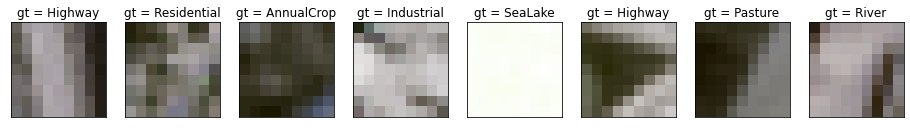

In [ ]:
dm.prepare_data()
print(f"train minibatch count: {len(dm.val_dataloader())}")
sample_images, sample_labels = next(iter(dm.val_dataloader()))
print(f"images tensor shape: {sample_images.shape}")  # BxCxHxW
print(f"labels tensor shape: {sample_labels.shape}")  # Bx1  (une étiquette par image du minibatch)
display_batch_size = min(8, BATCH_SIZE)
fig = plt.figure(figsize=(16, 3))
for ax_idx in range(display_batch_size):
  ax = fig.add_subplot(1, 8, ax_idx + 1)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  class_name = dm.class_names[sample_labels[ax_idx]]
  ax.set_title(f"gt = {class_name}")
  display = sample_images[ax_idx, ...].numpy()
  display = display.transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
  display = 128 * display + 127  # on inverse la normalisation
  display = cv.normalize(display, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
  plt.imshow(display)
plt.show()

In [ ]:
model = ResNet18()
model = model.cuda()
# Init model from datamodule's attributes
model = LitModel(model, learning_rate=1e-3)
model = model.load_from_checkpoint(checkpoint_path=checkpoint_callback.best_model_path)

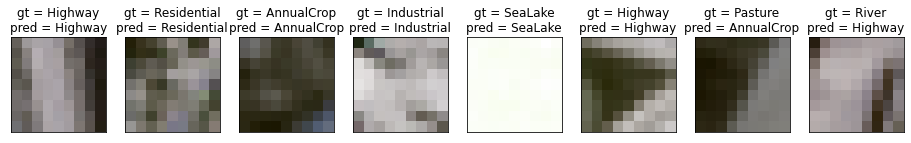

In [ ]:
sample_images, sample_labels = next(iter(dm.val_dataloader()))
model = model.cpu()
with torch.no_grad():
    #sample_images= torch.stack([sample_images[0,...], sample_images[1,...]])
    preds = model(sample_images)
preds = preds.cpu().topk(k=1, dim=1)[1]
display_batch_size = min(8, BATCH_SIZE)
fig = plt.figure(figsize=(16, 3))
for ax_idx in range(display_batch_size):
  ax = fig.add_subplot(1, 8, ax_idx + 1)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])
  gt_class_name = dm.class_names[sample_labels[ax_idx]]
  pred_class_name = dm.class_names[preds[ax_idx].item()]
  ax.set_title(f"gt = {gt_class_name}\npred = {pred_class_name}")
  display = sample_images[ax_idx, ...].numpy()
  display = display.transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
  display = 128 * display + 127  # on inverse la normalisation
  display = cv.normalize(display, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
  plt.imshow(display)
plt.show()

In [ ]:
import gdown
gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=1bOcqatxvij9VpfzE6iDJLFg0WBkt3NaW",
        '/content/best-model.ckpt'
    )

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1bOcqatxvij9VpfzE6iDJLFg0WBkt3NaW
To: /content/best-model.ckpt
100%|██████████| 134M/134M [00:01<00:00, 77.4MB/s]


'/content/best-model.ckpt'

In [ ]:
model = ResNet18()
model = model.cuda()
# Init model from datamodule's attributes
model = LitModel(model, learning_rate=1e-3)
model = model.load_from_checkpoint('/content/best-model.ckpt')

In [ ]:
# Simple lightning module
class MyLightningModule(LightningModule):
    def __init__(self, model, learning_rate, *args, **kwargs):
        super().__init__()
        self.model= model
        self.save_hyperparameters()
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)
model= MyLightningModule.load_from_checkpoint('/content/best-model.ckpt')

In [ ]:
model= model.model
print(model.fc.weight.shape)
print(model.fc.weight.view(model.fc.out_features, model.out_features, 1, 1).shape)
conv_layer = torch.nn.Conv2d(in_channels = model.out_features, out_channels = model.fc.out_features, kernel_size = 1)
print(conv_layer)
print(conv_layer.weight.shape)

torch.Size([10, 512])

torch.Size([10, 512, 1, 1])

Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))

torch.Size([10, 512, 1, 1])

In [ ]:
identity = torch.nn.Conv2d(3, 3, kernel_size=9, bias=False, padding=4)

print(identity.weight.shape)
weight= torch.zeros(identity.weight.shape)
weight[0,0,4,4]=1.0
weight[1,1,4,4]=1.0
weight[2,2,4,4]=1.0
identity.weight= torch.nn.Parameter(weight)

print(identity.weight)

torch.Size([3, 3, 9, 9])

Parameter containing:
tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]],

         [[0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0.]]]], requires_grad=True)

In [ ]:
class FullyConvResNet18(torch.nn.Module):
  # oui, un réseau peut contenir un réseau, la définition de 'Module' est très générique!
  def __init__(self, pre_existing_model, avgpool_size=0):
    super().__init__()

    self.pre_existing_model = pre_existing_model
    self.avgpool_size = avgpool_size
    self.finallayer = torch.nn.Conv2d(pre_existing_model.out_features,
                                      pre_existing_model.fc.out_features,
                                      kernel_size=1)
    # on réutilise les poids de la couche "fully connected" dans les noyaux 1x1 de la couche convolutive
    self.finallayer.weight = torch.nn.Parameter(pre_existing_model.fc.weight.view(pre_existing_model.fc.out_features,
                                                                                  pre_existing_model.out_features, 1, 1))
    self.finallayer.bias = torch.nn.Parameter(pre_existing_model.fc.bias)

  def forward(self, x):
    #print(x.shape)
    x = self.pre_existing_model.conv1(x)
    #print(x.shape)
    x = self.pre_existing_model.bn1(x)
    x = self.pre_existing_model.relu(x)
    x = self.pre_existing_model.maxpool(x)
    #print(x.shape)
    x = self.pre_existing_model.layer1(x)
    #print(x.shape)
    x = self.pre_existing_model.layer2(x)
    #print(x.shape)
    x = self.pre_existing_model.layer3(x)
    #print(x.shape)
    embedding = self.pre_existing_model.layer4(x)
    #print(embedding.shape)
    if self.avgpool_size > 0:
      embedding = torch.nn.functional.avg_pool2d(embedding, kernel_size=self.avgpool_size, stride=1)
    logits = self.finallayer(embedding)
    return logits


# pour contrôler le lissage, vous pouvez augmenter la taille du pooling ci-dessous
avg_pool_size = 0

fcmodel = FullyConvResNet18(model, avg_pool_size)


In [ ]:
import gdown

# on télécharge le jeu de données via Google Drive à l'aide de son identifiant unique
if not os.path.isfile("gatineau_dataset.zip"):
  gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id=14NrD3mTFqQKiZvmcMxYyACHYJSIZ4Mot",
        '/content/gatineau_dataset.zip'
    )
!unzip -qo /content/gatineau_dataset.zip


Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=14NrD3mTFqQKiZvmcMxYyACHYJSIZ4Mot
To: /content/gatineau_dataset.zip
100%|██████████| 34.7M/34.7M [00:00<00:00, 56.2MB/s]


In [ ]:
class TileParser(torch.utils.data.Dataset):

  def __init__(self, root, target_bands):
    assert os.path.isfile(root)
    self.samples = [root]
    self.target_bands = target_bands

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    raster_path = self.samples[idx]
    raster_ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    assert raster_ds is not None, f"File not found: {raster_path}"
    image = []
    for channel in self.target_bands:
        image_arr = raster_ds.GetRasterBand(channel).ReadAsArray()
        assert image_arr is not None, f"Band not found: {channel}"
        image.append(image_arr)
    image = np.dstack(image)
    raster_ds = None
    # normalize image here (with arbritrary values used for 8bit arrays)
    image = ((image.astype(np.float32) - 127) / 128).astype(np.float32)
    # convert numpy array to torch tensor
    image = torchvision.transforms.functional.to_tensor(image)
    return image

# instanciation du lecteur
tile_april = TileParser("gatineau_dataset/gatineau_20170429.tif", target_bands)
tile_june = TileParser("gatineau_dataset/gatineau_20170608.tif", target_bands)

# encore une fois, choisissez une seule image pour tester!
#tile = tile_april
tile = tile_june

print(f"input tile shape = {tile[0].shape}")

input tile shape = torch.Size([4, 1100, 1213])

In [ ]:
fcmodel.to(device)
model.to(device)
# on transforme l'image seule en 'minibatch' en ajoutant une dimension de batch...
tile_sample = tile[0].unsqueeze(0)
#tile_sample= tile_sample[0,:,:100,:100]
#tile_sample= torch.stack([tile_sample, tile_sample])
print(f"input tile shape = {tile_sample.shape}")
if use_cuda:
  tile_sample = tile_sample.cuda()
tile_pred = fcmodel(tile_sample).cpu()
print(f"output tile shape = {tile_pred[0].shape}")

input tile shape = torch.Size([1, 4, 1100, 1213])

output tile shape = torch.Size([10, 69, 76])

In [ ]:
print(f"input tensor shape = {tile_sample.shape}")
print(f"output tensor shape = {tile_pred.shape}")

input tensor shape = torch.Size([1, 4, 1100, 1213])

output tensor shape = torch.Size([1, 10, 69, 76])

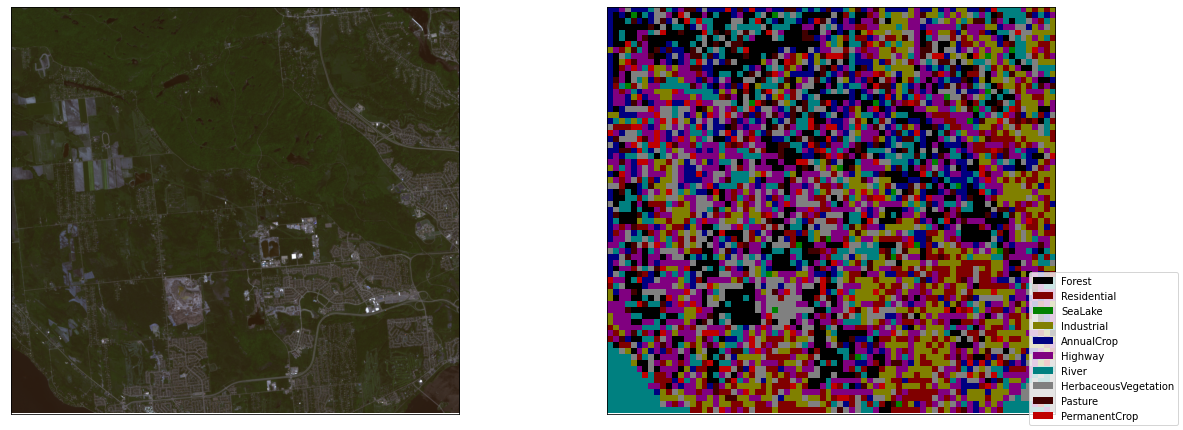

In [ ]:
# on va garder uniquement la classe la plus probable pour chaque pixel
tile_pred_top = tile_pred.topk(k=1, dim=1)[1].squeeze()

# pour coloration des prédictions
def get_label_color_mapping(idx):
  """Returns a color triplet for a given label index."""
  # https://gist.github.com/wllhf/a4533e0adebe57e3ed06d4b50c8419ae
  def bitget(byteval, ch):
      return (byteval & (1 << ch)) != 0
  r = g = b = 0
  for j in range(8):
      r = r | (bitget(idx, 0) << 7 - j)
      g = g | (bitget(idx, 1) << 7 - j)
      b = b | (bitget(idx, 2) << 7 - j)
      idx = idx >> 3
  return np.array([r, g, b], dtype=np.uint8)

color_lut = {idx: get_label_color_mapping(idx) for idx, lbl in enumerate(dataset.class_name)}
color_lut[255] = get_label_color_mapping(255)
class_map = {lbl: idx for idx, lbl in enumerate(dataset.class_name)}

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 2, 1)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
display = tile_sample[0, ...].cpu().numpy()
display = display.transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
display = display[..., :3]  # on garde les trois premiers canaux (pour affichage seulement)
display = 128 * display + 127  # on inverse la normalisation
display = np.clip(display, 0, 4000)
display = cv.normalize(display, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
plt.imshow(display)

ax = fig.add_subplot(1, 2, 2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
display_mask = np.empty(shape=(tile_pred_top.shape[0], tile_pred_top.shape[1], 3)).astype(np.uint8).reshape(-1, 3)
mask = tile_pred_top.reshape(-1)
for px_idx in range(len(mask)):
  display_mask[px_idx, :] = color_lut[mask[px_idx].item()]
display_mask = display_mask.reshape((tile_pred_top.shape[0], tile_pred_top.shape[1], 3))
plt.imshow(display_mask)

legend_handles = [matplotlib.patches.Patch(facecolor=color_lut[idx]/255, label=lbl) for lbl, idx in class_map.items()]
fig.legend(handles=legend_handles, loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
tile_width, tile_height = tile[0].shape[2], tile[0].shape[1]
patch_width, patch_height = 9, 9
output = np.full((tile_height, tile_width, 3), fill_value=0, dtype=np.uint8)

curr_iter = 0
last_print_time = time.time()

inf_batch_size = 256
image = tile[0]

patch_tensor = []
for row_idx in range(patch_height//2, tile_height - patch_height//2):
  for col_idx in range(patch_width//2, tile_width - patch_width//2):
    patch_tl = (row_idx-patch_height//2, col_idx-patch_width//2)
    patch_br = (patch_tl[0]+patch_height, patch_tl[1]+patch_width)
    patch = image[:, patch_tl[0]:patch_br[0], patch_tl[1]:patch_br[1]]

    if len(patch_tensor) == inf_batch_size:
      patch_batch = torch.stack([t[1] for t in patch_tensor])
      if use_cuda:
        patch_batch = patch_batch.cuda()
      with torch.no_grad():
        preds = fcmodel(patch_batch).topk(k=1, dim=1)[1].cpu()
      for pred, loc in zip(preds, [t[0] for t in patch_tensor]):
        output[loc[0], loc[1], :] = color_lut[pred.item()]
      patch_tensor = []
    else:
      patch_tensor.append(((row_idx, col_idx), patch))

    if time.time() - last_print_time > 10:
      last_print_time = time.time()
      print(f"per-pixel inference @ iteration {curr_iter+1}/{output.shape[0]*output.shape[1]}...")
    curr_iter += 1

if len(patch_tensor) != 0:
  patch_batch = torch.stack([t[1] for t in patch_tensor])
  if use_cuda:
    patch_batch = patch_batch.cuda()
  with torch.no_grad():
    preds = model(patch_batch).topk(k=1, dim=1)[1].cpu()
  for pred, loc in zip(preds, [t[0] for t in patch_tensor]):
    output[loc[0], loc[1], :] = color_lut[pred.item()]


per-pixel inference @ iteration 184269/1334300...

per-pixel inference @ iteration 309685/1334300...

per-pixel inference @ iteration 480847/1334300...

per-pixel inference @ iteration 669999/1334300...

per-pixel inference @ iteration 822044/1334300...

per-pixel inference @ iteration 970432/1334300...

per-pixel inference @ iteration 1160394/1334300...

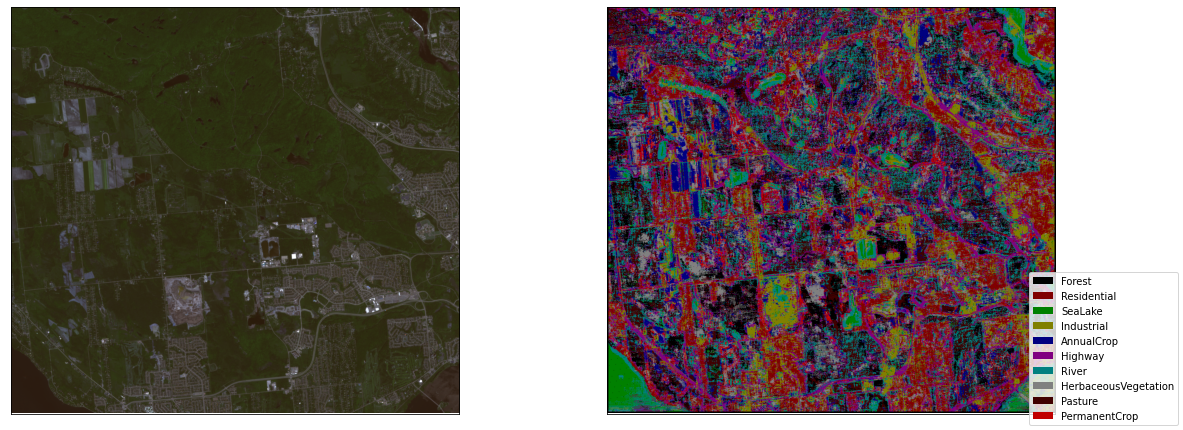

In [ ]:

fig = plt.figure(figsize=(18, 6))

ax = fig.add_subplot(1, 2, 1)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
display = image.cpu().numpy()
display = display.transpose((1, 2, 0))  # CxHxW => HxWxC (tel que demandé par matplotlib)
display = display[..., :3]  # on garde les trois premiers canaux (pour affichage seulement)
display = 128 * display + 127  # on inverse la normalisation
display = np.clip(display, 0, 4000)
display = cv.normalize(display, dst=None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_8U)
plt.imshow(display)

ax = fig.add_subplot(1, 2, 2)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
plt.imshow(output)

legend_handles = [matplotlib.patches.Patch(facecolor=color_lut[idx]/255, label=lbl) for lbl, idx in class_map.items()]
fig.legend(handles=legend_handles, loc="lower right")

plt.tight_layout()
plt.show()